## LSD

In [1]:
#Libraries 
import os
import time
import math
import numpy as np
import pandas as pd
import scipy
import scipy.signal as spsg
from scipy import stats
from scipy.io import loadmat
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock
from data.labels_brain import reorder_matrix




random.seed(42)

### Reading Data

In [2]:
# Read the data
data_path= "C:/Users/diego/Desktop/phase_coherance_consciousness/data"

#Awake
data_LSD = os.path.join(data_path, "LSD_TS_FC.mat")
data_LSD = loadmat(data_LSD)
data_LSD = data_LSD["DataCorrel"].flatten()

#Some of the data is corrupted, we chose manually the patiens we want to read.
num_patients=range(data_LSD["LSD_TS"].shape[0])
num=len(num_patients)


LSDACAT = np.hstack([data_LSD["LSD_TS"][i] for i in num_patients])
LSDPCAT = np.hstack([data_LSD["PCB_TS"][i] for i in num_patients])

LSD_Signals = np.hstack((LSDACAT, LSDPCAT))
print(f"LSD concatenated signals: {LSD_Signals.shape} from {data_LSD.shape[0]} patients.")

LSD concatenated signals: (90, 6937) from 16 patients.


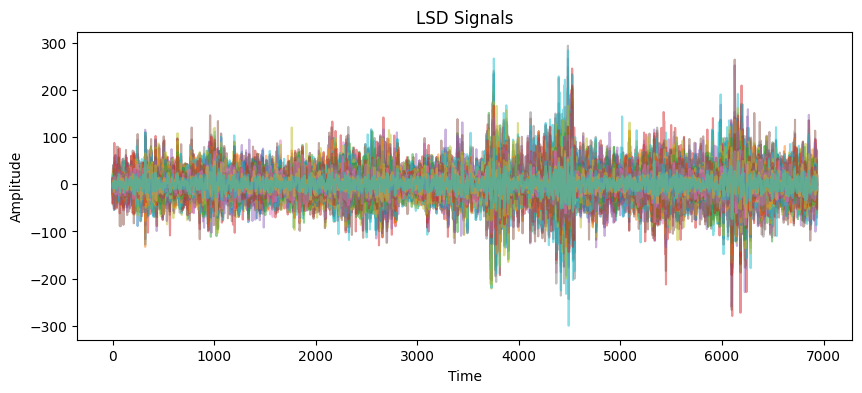

In [3]:
# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(LSD_Signals.T, alpha=0.5)
plt.title("LSD Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Extract Size and Features

In [4]:
#Number of Regions and Total Time
ROI,time_length = LSD_Signals.shape

# Loop over each region to extract the lenght of each signal.
Time_per_subj = np.zeros(ROI, dtype=int)
for i in range(ROI):
    Time_per_subj[i] = len(LSD_Signals[i])


print(f" Number of Regions (ROI): {ROI} \n Total Time: {time_length}")

 Number of Regions (ROI): 90 
 Total Time: 6937


### Import the Connectoma 

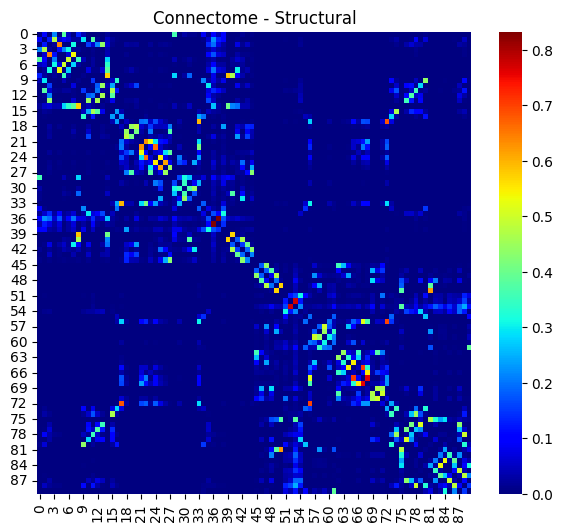

In [5]:
# Import the atlas
data_connectome = os.path.join(data_path, "./structural.mat")
CC = loadmat(data_connectome)['A']

# Plot it
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(CC, cmap='jet',cbar=True, ax=ax)
ax.set_title(f"Connectome - Structural")
plt.show()

In [6]:
CC_reordered, new_labels, new_group_labels = reorder_matrix(connectivity_matrix=CC)
CC_reordered = pd.DataFrame(CC_reordered, index=new_labels, columns=new_labels)
CC_reordered["Group"] = new_group_labels
CC_reordered.head()

Cingulum_Ant_L  Cingulum_Ant_R  Cingulum_Mid_L  \
Cingulum_Ant_L         0.000000        0.364909        0.447285   
Cingulum_Ant_R         0.364909        0.000000        0.172070   
Cingulum_Mid_L         0.447285        0.172070        0.000000   
Cingulum_Mid_R         0.003396        0.006958        0.002129   
Cingulum_Post_L        0.000000        0.000000        0.000000   

                 Cingulum_Mid_R  Cingulum_Post_L  Cingulum_Post_R  \
Cingulum_Ant_L         0.003396         0.000000         0.000000   
Cingulum_Ant_R         0.006958         0.000000         0.000000   
Cingulum_Mid_L         0.002129         0.000000         0.000000   
Cingulum_Mid_R         0.000000         0.178258         0.005520   
Cingulum_Post_L        0.178258         0.000000         0.073147   

                 Frontal_Sup_L  Frontal_Sup_R  Frontal_Sup_Orb_L  \
Cingulum_Ant_L             0.0       0.002057            0.00000   
Cingulum_Ant_R             0.0       0.000000            0.00084   
Cingulum_Mid_L             0.0       0.000702            0.00039   
Cingulum_Mid_R             0.0       0.000000            0.00000   
Cingulum_Post_L            0.0       0.000000            0.00000   

                 Frontal_Sup_Orb_R  ...  Temporal_Sup_R  Temporal_Pole_Sup_L  \
Cingulum_Ant_L            0.009036  ...             0.0                  0.0   
Cingulum_Ant_R            0.021055  ...             0.0                  0.0   
Cingulum_Mid_L            0.004731  ...             0.0                  0.0   
Cingulum_Mid_R            0.000000  ...             0.0                  0.0   
Cingulum_Post_L           0.000000  ...             0.0                  0.0   

                 Temporal_Pole_Sup_R  Temporal_Mid_L  Temporal_Mid_R  \
Cingulum_Ant_L                   0.0             0.0             0.0   
Cingulum_Ant_R                   0.0             0.0             0.0   
Cingulum_Mid_L                   0.0             0.0             0.0   
Cingulum_Mid_R                   0.0             0.0             0.0   
Cingulum_Post_L                  0.0             0.0             0.0   

                 Temporal_Pole_Mid_L  Temporal_Pole_Mid_R  Temporal_Inf_L  \
Cingulum_Ant_L                   0.0                  0.0        0.000000   
Cingulum_Ant_R                   0.0                  0.0        0.000000   
Cingulum_Mid_L                   0.0                  0.0        0.000000   
Cingulum_Mid_R                   0.0                  0.0        0.000000   
Cingulum_Post_L                  0.0                  0.0        0.007427   

                 Temporal_Inf_R      Group  
Cingulum_Ant_L         0.000000  Cingulate  
Cingulum_Ant_R         0.000000  Cingulate  
Cingulum_Mid_L         0.000000  Cingulate  
Cingulum_Mid_R         0.000000  Cingulate  
Cingulum_Post_L        0.011651  Cingulate  

[5 rows x 89 columns]

In [7]:
np.info(CC)

class:  ndarray
shape:  (90, 90)
strides:  (8, 720)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x246ea9f4c60
byteorder:  little
byteswap:  False
type: float64


### Preprocess Functions 

In [8]:
# Function to apply a Butterworth bandpass filter to a time series.
# It is particularly useful for removing noise and smoothing the signal in the specified frequency range.
def butterworth_filtering(ts):
    """
    Apply a Butterworth bandpass filter to the input time series `ts`.

    Parameters:
    ts : array-like
        The input time series (1D or 2D array).
        
    Returns:
    filtered_ts : array-like
        The filtered time series, same shape as input.
        
    Notes:
    - The filter settings are dependent on the experimental setup (TR = 2.4 seconds).
    - A 3rd-order Butterworth bandpass filter is applied with cutoff frequencies of 0.01 and 0.2 times the Nyquist frequency.
    - The Nyquist frequency is determined by the repetition time (TR = 2.4s).
    """
    # Parameters
    n_order = 3  # Filter order
    TR = 2.4  # Repetition time (in seconds, relevant for fMRI experiments)
    Nyquist_freq = 0.5 / TR  # Nyquist frequency (half the sampling rate)
    low_f = 0.01 / Nyquist_freq  # Low cutoff frequency (fraction of Nyquist)
    high_f = 0.2 / Nyquist_freq  # High cutoff frequency (fraction of Nyquist)
    
    # Design the Butterworth bandpass filter
    b, a = spsg.iirfilter(n_order, (low_f, high_f), btype='bandpass', ftype='butter', output='ba')
    
    # Apply the filter to the time series using zero-phase filtering
    filtered_ts = spsg.filtfilt(b, a, ts, axis=-1)
    
    return filtered_ts

In [9]:
def adif(a, b):
    """
    Calculate the angular difference between two angles `a` and `b` in radians.

    Parameters:
    a, b : float
        The input angles in radians.
        
    Returns:
    float
        The angular difference between the two angles, always in the range [0, π]. The smallest angel diffence.
    """
    if abs(a - b) > math.pi:
        return 2 * math.pi - abs(a - b)
    else:
        return abs(a - b)


### Phase difference between each pair of regions

In [10]:
timeseriedata = np.empty((ROI, time_length))
Amplitude = np.empty((ROI, time_length))
Phases = np.empty((ROI, time_length))

# For each Region we preprocess the signal to exctract instantaneous phase
for i in range(ROI):

    #Extract the signal
    ts = LSD_Signals[i,:]

    # Normalize the signal using Z-score
    ts_z = stats.zscore(ts)

    # Subtract the mean
    ts_z = ts_z-np.mean(ts_z,axis=0)

    # Apply the Butterworth filter 
    #ts_filtered = butterworth_filtering(ts_z)
    ts_filtered = ts_z
    
    timeseriedata[i, :] = ts_filtered

    # Perform the Hilbert transform
    hilbert_tf = spsg.hilbert(ts_z, axis=-1)
    Amplitude[i, :] = np.abs(hilbert_tf)

    # Instantaneous phase
    Phases[i, :] = np.angle(hilbert_tf)

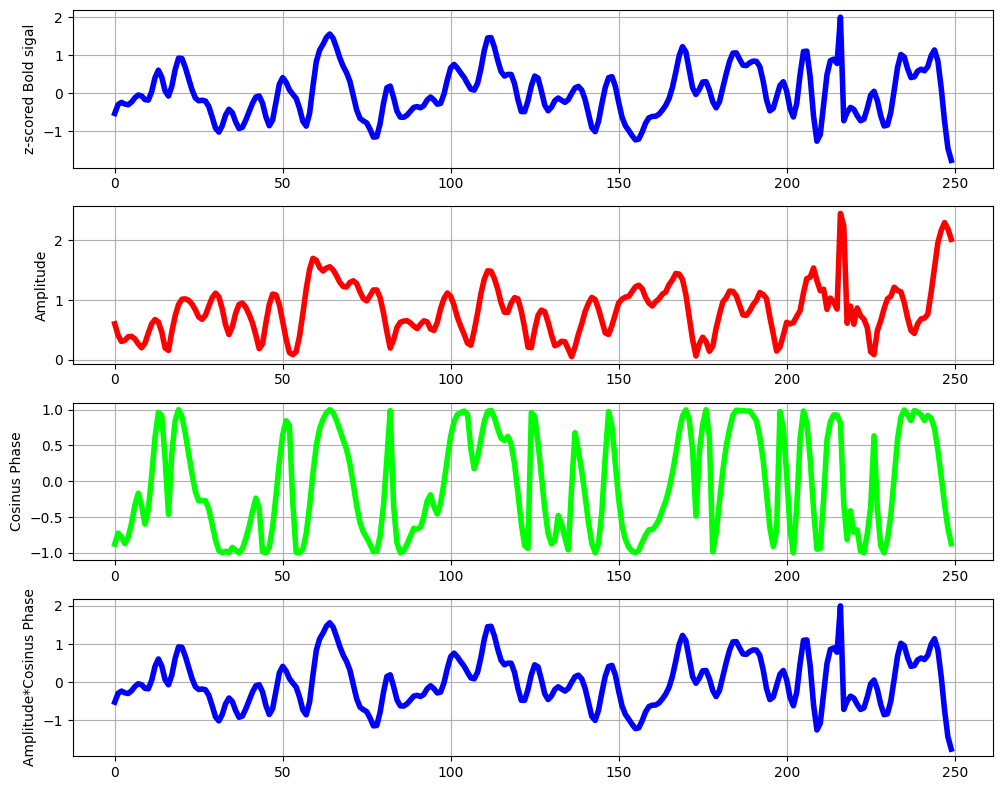

In [11]:
def createfigure(Y1, Y2, Y3, Y4):
    """
    Creates a figure with 4 vertical subplots to visualize:
    - Y1: Z-scored signal (e.g., bold)
    - Y2: Amplitude
    - Y3: Cosine of the phase
    - Y4: Amplitude * cosine of the phase
    """

    fig, axs = plt.subplots(4, 1, figsize=(10, 8))
    
    axs[0].plot(Y1, linewidth=4, color=[0, 0, 1])
    axs[0].set_ylabel('z-scored Bold sigal')
    axs[0].grid(True) 
    
    axs[1].plot(Y2, linewidth=4, color=[1, 0, 0])
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)
    
    
    axs[2].plot(Y3, linewidth=4, color=[0, 1, 0])
    axs[2].set_ylabel('Cosinus Phase')
    axs[2].grid(True)
    
    axs[3].plot(Y4, linewidth=4, color=[0, 0, 1])
    axs[3].set_ylabel('Amplitude*Cosinus Phase')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

#We replicate a signal
Y1 = timeseriedata[0, :250]
Y2 = Amplitude[0, :250]
Y3 = np.cos(Phases[0, :250])
Y4 = Amplitude[0, :250] * np.cos(Phases[0, :250])
createfigure(Y1, Y2, Y3, Y4)

### Vectorized Computation for each time instant 

In [12]:
# Number of pairs (only the lower part of the matrix): ROI*(ROI-1)/2
row_idx, col_idx = np.tril_indices(ROI, k=-1)
sorted_indices = np.lexsort((row_idx, col_idx))
lower_indices_corrected = (row_idx[sorted_indices], col_idx[sorted_indices])


num_pairs = len(lower_indices_corrected[0])
pattern = np.empty((num_pairs, time_length))


# Vectorized computation for each time instant
for t in range(time_length):
    patt = np.empty((ROI, ROI))
    for i in range(ROI):
        for j in range(i):
            patt[i,j] = np.cos(adif(Phases[i,t],Phases[j,t]))
    pattern[:, t] = patt[lower_indices_corrected]
    

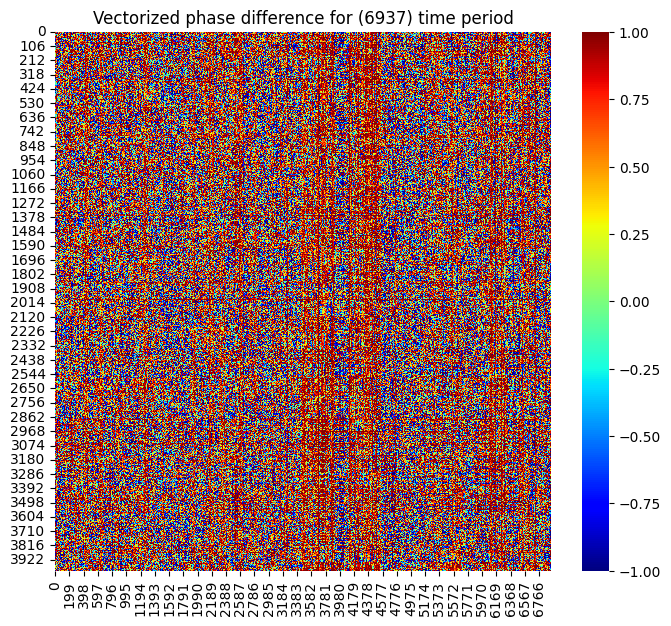

In [13]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(pattern, cmap='jet', vmin=-1, vmax=1, cbar=True, ax=ax)
ax.set_title(f"Vectorized phase difference for ({time_length}) time period")
plt.show()

### Remove Empty Images

In [14]:
all_pattern2D = pattern.T


# Empty Images
print("Size before removing empty images:", all_pattern2D.shape)
good_pattern = np.sum(np.abs(all_pattern2D), axis=1) > 0
all_pattern2D = all_pattern2D[good_pattern, :]  
print("Size after removing empty images:", all_pattern2D.shape)

# Outliers
# D = squareform(pdist(all_pattern2D, metric='cityblock'))  
# D = zscore(np.mean(D, axis=1))  
# good_pattern = D < 3 
# all_pattern2D = all_pattern2D[good_pattern, :]  
print("Size after removing outliers:", all_pattern2D.shape)


Size before removing empty images: (6937, 4005)
Size after removing empty images: (6937, 4005)
Size after removing outliers: (6937, 4005)


### K-Means

In [15]:
# Parameters
opts = {"max_iter": 200}
Kmeans_results = {} 

# Manhattan distance
def compute_manhattan_distance(data_point, centroids, cluster_labels):
    return cityblock(data_point, centroids[cluster_labels])

# KMeans clustering for each k (currently just k=5)
for k in [5]:
    kmeans = KMeans(n_clusters=k, max_iter=opts["max_iter"], n_init=1, random_state=0)
    kmeans.fit(all_pattern2D)

    cidx_Pha = kmeans.labels_
    ctrs_Pha = kmeans.cluster_centers_

    #Manhattan distances
    sum_D_Pha = np.sum([compute_manhattan_distance(all_pattern2D[i], ctrs_Pha, cidx_Pha[i]) for i in range(all_pattern2D.shape[0])])

    Kmeans_results[k] = {
        "cidx_Pha": cidx_Pha,
        "ctrs_Pha": ctrs_Pha,
        "sum_D_Pha": sum_D_Pha
    }

# Verify Dimensions
print(f"cidx_Pha shape: {Kmeans_results[5]['cidx_Pha'].shape}")
print(f"ctrs_Pha shape: {Kmeans_results[5]['ctrs_Pha'].shape}")
print(f"sum_D_Pha: {Kmeans_results[5]['sum_D_Pha']}")


cidx_Pha shape: (6937,)
ctrs_Pha shape: (5, 4005)
sum_D_Pha: 15219263.012145307


### Visualization

In [16]:
# Clustering States
n_state = 5
cidx = Kmeans_results[n_state]['cidx_Pha']  
L = cidx.shape[0]  
T_shift = 9  

# Reordering the structural connectivity matrix
id_aal = np.arange(1, 91) 
id_deco = np.concatenate([np.linspace(1, 89, 45, dtype=int), np.linspace(2, 90, 45, dtype=int)[::-1]])
deco_to_aal_mapping = np.searchsorted(id_aal, id_deco)  
CC2 = CC[np.ix_(deco_to_aal_mapping, deco_to_aal_mapping)] 
VC = CC.flatten().astype(np.float64)

# Compute correlations between centroids and connectome
CCA = np.zeros(n_state)
for i in range(n_state):
    centroid_vector = Kmeans_results[n_state]['ctrs_Pha'][i, :]
    QQ = squareform(centroid_vector) 
    VA = QQ.flatten()
    MC = np.corrcoef(VA, VC)  # Correlation with the connectome
    CCA[i] = MC[0, 1]

B = np.sort(CCA)
I = np.argsort(CCA)


rate = np.zeros(n_state)
ratea = np.zeros(n_state)
rateb = np.zeros(n_state)

denom = L - 2 * T_shift
mid = len(cidx) // 2  #We concatenated 2 time series (drug + placebo)


for bst in range(n_state):
    rate[bst]  = np.sum(cidx == I[bst]) / denom
    ratea[bst] = np.sum(cidx[:mid] == I[bst]) / denom
    rateb[bst] = np.sum(cidx[mid:] == I[bst]) / denom


# Compute cumulative time spent per subject
times_matrix_k = np.zeros((num, 2))
times_matrix_p = np.zeros((num, 2))


for idx, i in enumerate(num_patients):
    size_value_k = data_LSD[i]['LSD_TS'].shape[1]
    size_value_p = data_LSD[i]['PCB_TS'].shape[1]

    times_matrix_k[idx, 0] = size_value_k
    times_matrix_p[idx, 0] = size_value_p

    times_matrix_k[idx, 1] = size_value_k if idx == 0 else times_matrix_k[idx-1, 1] + size_value_k
    times_matrix_p[idx, 1] = size_value_p if idx == 0 else times_matrix_p[idx-1, 1] + size_value_p

scratekt = np.zeros((num, n_state))
scratektp = np.zeros((num, n_state))

for s in range(num):
    for j in range(n_state):
        if s == 0:
            scratekt[s, j] = np.sum(cidx[:int(times_matrix_k[s, 1])] == I[j]) / times_matrix_k[0, 1]
            scratektp[s, j] = np.sum(cidx[3465:3465 + int(times_matrix_p[s, 1])] == I[j]) / times_matrix_p[0, 1]
        else:
            scratekt[s, j] = np.sum(cidx[int(times_matrix_k[s-1, 1]):int(times_matrix_k[s, 1])] == I[j]) / times_matrix_k[0, 1]
            scratektp[s, j] = np.sum(cidx[3465 + int(times_matrix_p[s-1, 1]): 3465 + int(times_matrix_p[s, 1]) - 20] == I[j]) / times_matrix_p[0, 1]


CH = np.zeros((num * 2, n_state))
for i in range(n_state):
    CH[:, i] = np.concatenate([scratekt[:, i], scratektp[:, i]])

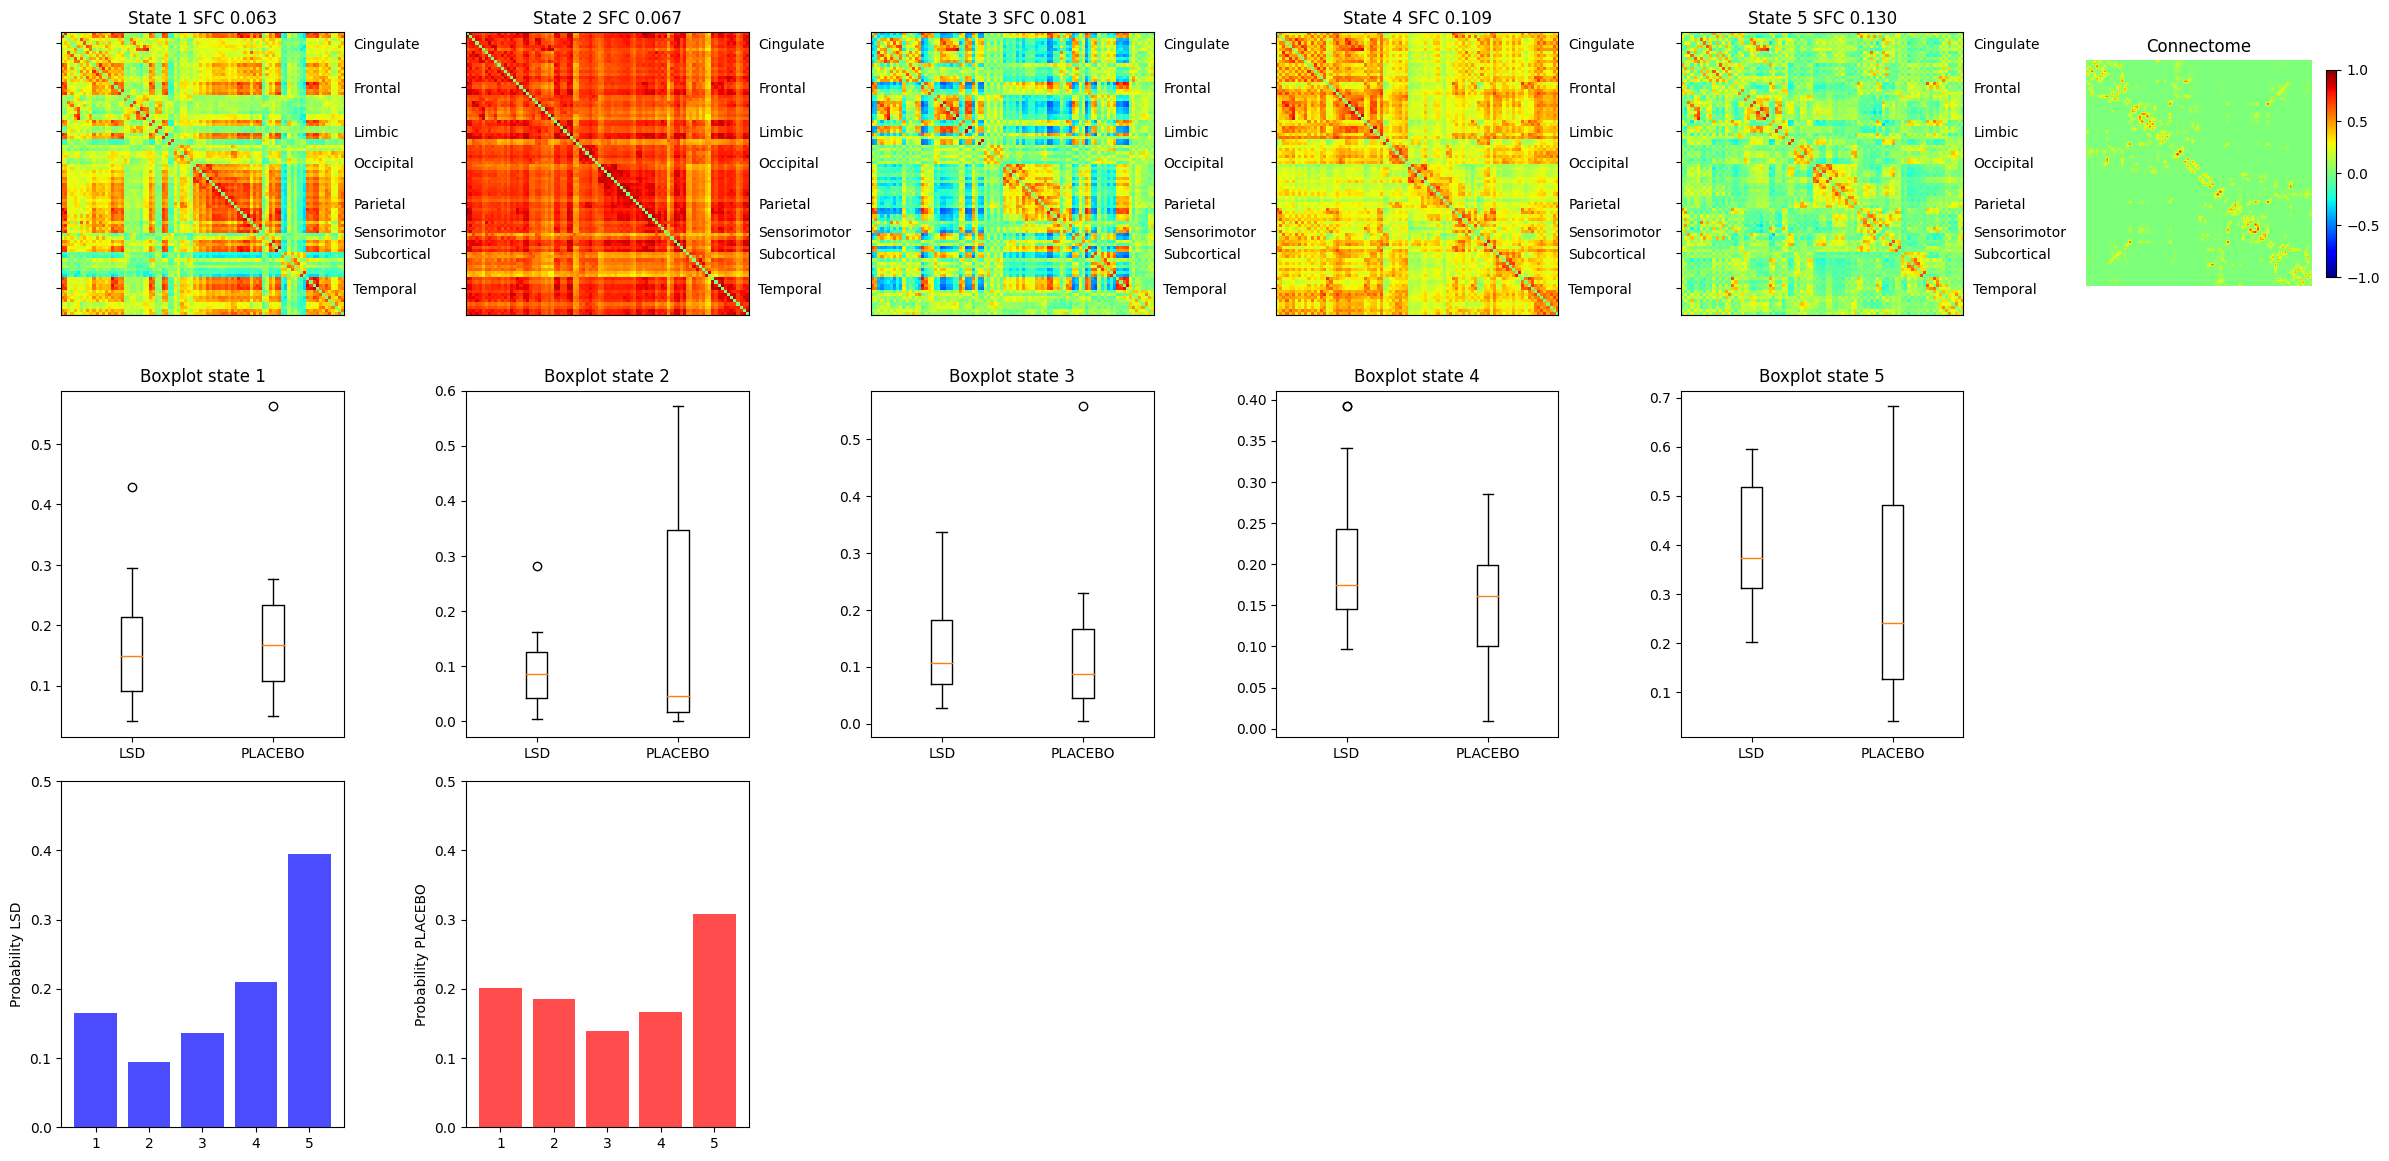

In [17]:
fig, axs = plt.subplots(3, n_state + 1, figsize=(4*(n_state+1), 12))

#Correlation matrices of each state
for i in range(n_state):
    QQ = squareform(Kmeans_results[n_state]['ctrs_Pha'][I[i], :])

    labels = reorder_matrix(QQ)[2] 
    unique_labels, indices = np.unique(labels, return_index=True)
    centers = [(indices[j] + (indices[j+1] if j+1 < len(indices) else len(labels))) / 2 for j in range(len(indices))]

    im = axs[0, i].imshow(QQ, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].set_title(f"State {i+1} SFC {B[i]:.3f}")
    axs[0,i].set_yticks(centers)
    axs[0,i].set_yticklabels(unique_labels)
    axs[0,i].tick_params(axis="y", labelright=True, labelleft=False)
    axs[0,i].set_xticks([]) 
    axs[0,i].tick_params(axis="x", which="both", bottom=False, top=False)  

#Connectome matrix
axs[0, n_state].imshow(CC, vmin=-1, vmax=1, cmap='jet')
axs[0, n_state].set_title("Connectome")
axs[0, n_state].axis("off")
plt.colorbar(im, ax=axs[0, n_state], shrink=0.6)

#Boxplots for each state
for i in range(n_state):
    axs[1, i].boxplot([CH[:num, i], CH[num:, i]], labels=["LSD", "PLACEBO"])
    axs[1, i].set_title(f"Boxplot state {i+1}")
axs[1, n_state].axis('off')

#Bar plots for state probabilities in MDMA and PLACEBO
axs[2, 0].bar(np.arange(1, n_state+1), ratea/np.sum(ratea), color='blue', alpha=0.7)
axs[2, 0].set_ylim([0, 0.5])
axs[2, 0].set_ylabel('Probability LSD')

axs[2, 1].bar(np.arange(1, n_state+1), rateb/np.sum(rateb), color='red', alpha=0.7)
axs[2, 1].set_ylim([0, 0.5])
axs[2, 1].set_ylabel('Probability PLACEBO')


# Hide remaining columns
for j in range(2, n_state+1):
    axs[2, j].axis('off')

plt.tight_layout()
plt.show()


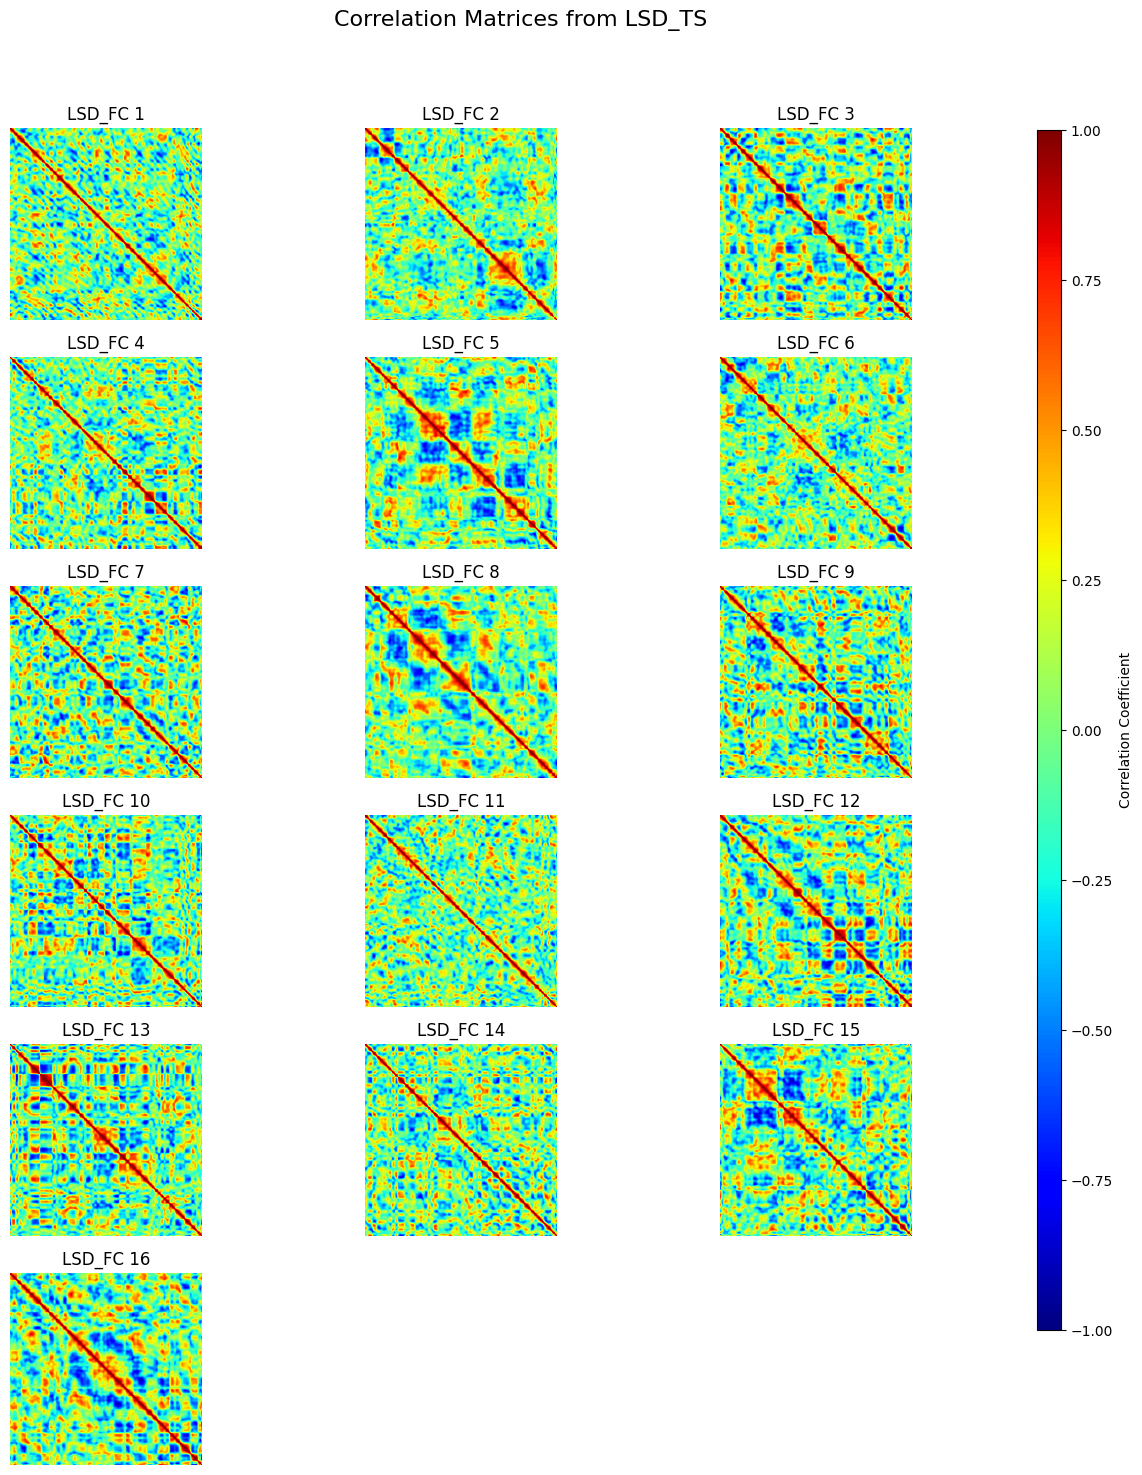

In [18]:
fig, axs = plt.subplots(int(np.ceil(num/3)), 3, figsize=(12, 15))

for k in range(num):
    corr_mat = np.corrcoef(data_LSD[k]['LSD_TS'].T)
    
    row = k // 3  
    col = k % 3
    ax = axs[row, col]
    
    # Display the correlation matrix 
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap='jet')
    ax.axis("off")
    ax.set_title(f"LSD_FC {k+1}") 

for k in range(num, int(np.ceil(num/3)*3)):
    row = k // 3
    col = k % 3
    axs[row, col].axis('off')

plt.set_cmap('jet')
fig.suptitle('Correlation Matrices from LSD_TS', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax, label='Correlation Coefficient')
plt.show()


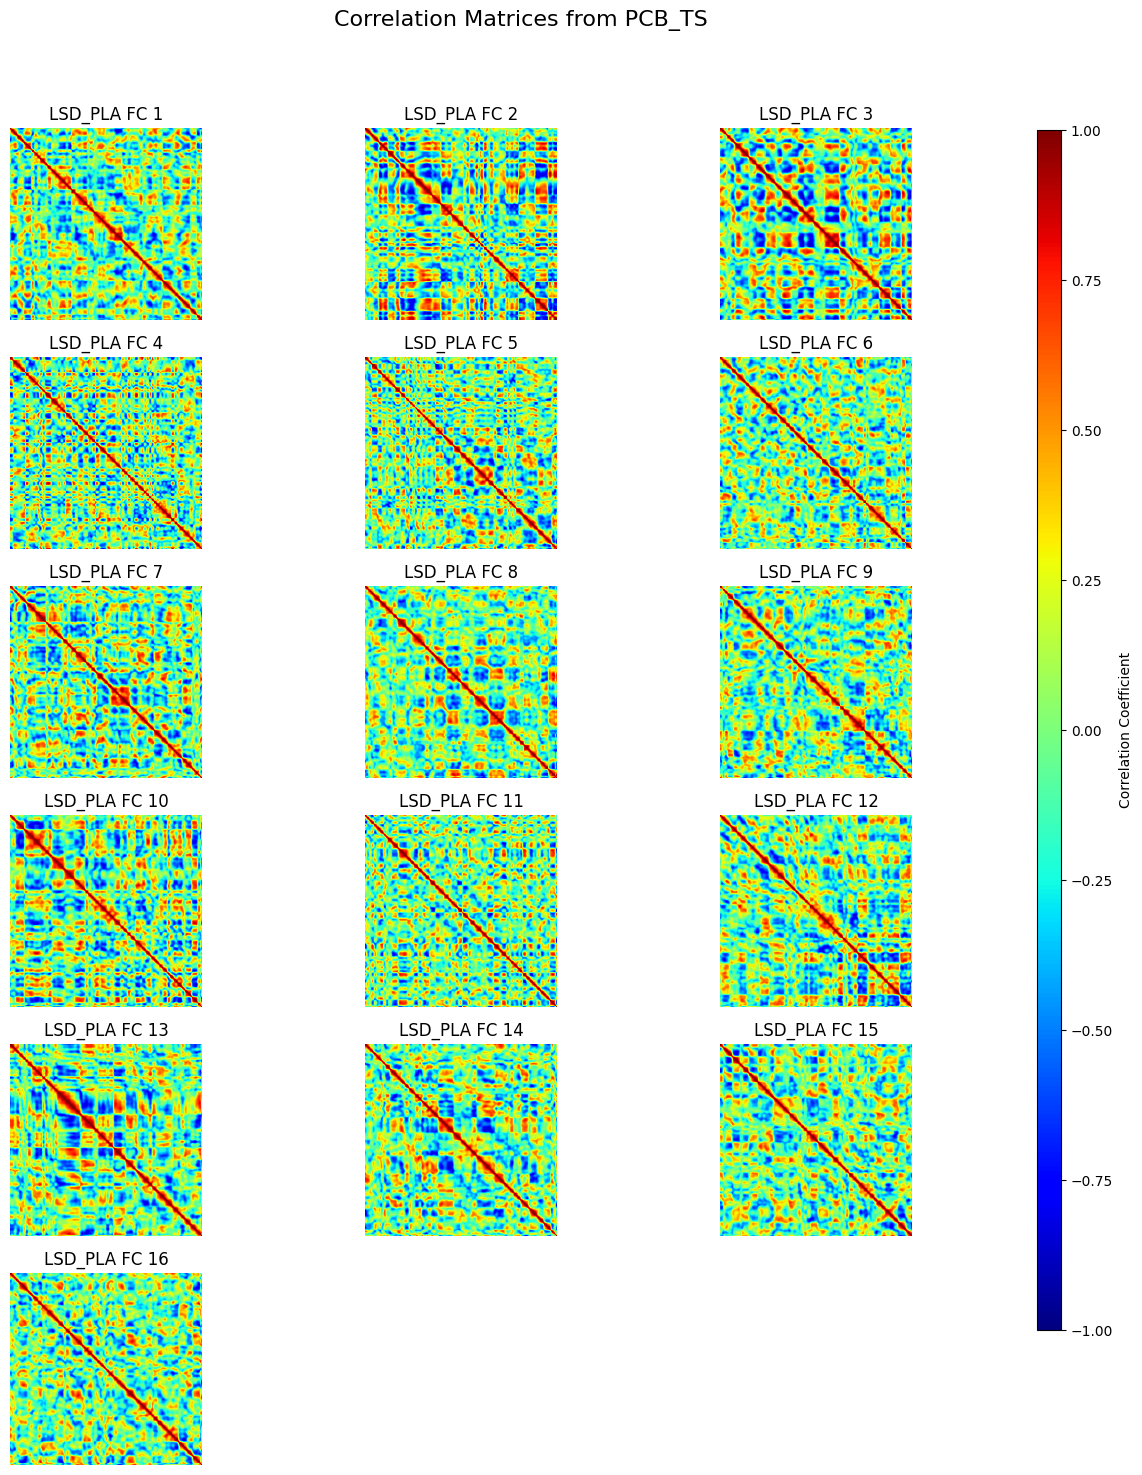

In [19]:
# PCB_TS correlation matrices
fig2, axs2 = plt.subplots(int(np.ceil(num/3)), 3, figsize=(12, 15))


for k in range(num):
    # Compute the correlation matrix for PCB_TS data 
    corr_mat = np.corrcoef(data_LSD[k]['PCB_TS'].T)
    
    row = k // 3
    col = k % 3
    ax = axs2[row, col]
    
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap='jet')
    ax.axis("off")
    ax.set_title(f"LSD_PLA FC {k+1}")

for k in range(num, int(np.ceil(num/3)*3)):
    row = k // 3
    col = k % 3
    axs2[row, col].axis('off')

plt.set_cmap('jet')
fig2.suptitle('Correlation Matrices from PCB_TS', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
cbar_ax2 = fig2.add_axes([0.93, 0.1, 0.02, 0.8])
fig2.colorbar(im, cax=cbar_ax2, label='Correlation Coefficient')
plt.show()